# Making a movie of voltage activity

We'll create a simple network made up of one imported morphology.

First we need to download the morphology.

Then we need to import the morphology.

In [51]:
import os

from netpyne import specs, sim
%matplotlib

filename = 'synthetic-3-cells.tif'

folder = os.path.splitext(filename)[0]

if not os.path.exists(folder):
    from rivunetpy.rtracenet import trace_net
    trace_net(filename)     # Trace

swc_filenames = []
for file in os.listdir(folder):
    if os.path.splitext(file)[-1] == '.swc':
        swc_filenames.append(file)

netParams = specs.NetParams()
netParams.sizeX = 300             # x-dimension (horizontal length) size in um
netParams.sizeY = 300            # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 600   


cell_labels = []
for ii, swc_fname in enumerate(swc_filenames):
    label = f'swc_{ii:04d}'
    
    cellRule = netParams.importCellParams(
        label=label, 
        conds={'cellType': 'PYR'},
        fileName=os.path.join(folder, swc_fname), 
        cellName='swc_fname',
        )
    
    cell_labels.append(label)
    
    # For convenience, we'll rename the first soma section in the morphology from `soma_0` to `soma`.
    netParams.renameCellParamsSec(label, 'soma_0', 'soma')
    
    # Next we'll add Hodgkin-Huxley mechanisms to the soma and a passive leak mechanism everywhere else.
    for secName in cellRule['secs']:
        cellRule['secs'][secName]['geom']['cm'] = 1
        if secName.startswith('soma'):
            cellRule['secs'][secName]['mechs']['hh'] = {
                'gnabar': 0.12, 
                'gkbar': 0.036, 
                'gl': 0.003, 
                'el': -70,
                }
        else:
            cellRule['secs'][secName]['mechs']['pas'] = {
                'g': 0.0000357, 
                'e': -70,
                }
        
    # Now we'll make a population out of our imported cell.
    # netParams.popParams[ii] = {'cellType': 'swc_cell', 'numCells': 1}

    netParams.popParams[label] = {'cellType': 'PYR',
                                  'numCells': 1}
    

num_cells = len(swc_filenames)
print(cell_labels)

Using matplotlib backend: QtAgg
['swc_0000', 'swc_0001', 'swc_0002']


Now we'll add a stimulation into the soma to cause an action potential.

In [52]:
netParams.synMechParams['exc'] = {
    'mod': 'Exp2Syn', 
    'tau1': 0.1, 
    'tau2': 5.0, 
    'e': 0,
}

netParams.stimSourceParams['bkg'] = {
    'type': 'NetStim', 
    'rate': 10, 
    'noise': 0.0,
}

# Apply stimulation to random cell:
# import random

# stim_cell_label = random.choice(cell_labels)
# print(f'Applying stimulation to cell {stim_cell_label}')
stim_cell_label = 'PYR'

netParams.stimTargetParams[f'bkg->{stim_cell_label}'] = {
    'source': 'bkg', 
    'conds': {'cellType': 'PYR'}, 
    'weight': 0.1, 
    'delay': 10, 
    'synMech': 'exc',
}

In [53]:

## Connectivity params

netParams.connParams['recurrent'] = {
    'preConds': {'cellType': 'PYR'}, 'postConds': {'cellType': 'PYR'},  #  PYR -> PYR random
    'connFunc': 'convConn',           # connectivity function (random)
    'convergence': 'uniform(0,10)',   # max number of incoming conns to cell
    'weight': 0.001,                  # synaptic weight
    'delay': 5,                       # transmission delay (ms)
    'sec': 'soma'}                    # section to connect to

In [54]:
## Cell connectivity rules

# netParams.connParams['0->1'] = { # label
#         'preConds': {'pop': 0},   # conditions of presyn cells
#         'postConds': {'pop': 1},  # conditions of postsyn cells
#         'probability': 0.5,         # probability of connection
#         'weight': 0.01,             # synaptic weight
#         'delay': 5,                 # transmission delay (ms)
#         'synMech': 'exc'}           # synaptic mechanism

# netParams.connParams['1->2'] = { # label
#         'preConds': {'pop': 1},   # conditions of presyn cells
#         'postConds': {'pop': 2},  # conditions of postsyn cells
#         'probability': 0.5,         # probability of connection
#         'weight': 0.01,             # synaptic weight
#         'delay': 5,                 # transmission delay (ms)
#         'synMech': 'exc'}           # synaptic mechanism

Then we'll set up the simulation configuration.

In [55]:
cfg = specs.SimConfig()
cfg.filename = 'plotshape'
cfg.duration = 30
cfg.recordTraces = {'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}}
cfg.recordStep = 0.5
cfg.analysis['plotTraces'] = {'include': ['all'], 'showFig': True}    
cfg.analysis['plot2Dnet'] = {'saveFig': False, 'showFig': True}    

At this point, we could complete everything with `sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg)`, but we want to plot a movie frame at a certain interval, so we need to execute the simulation commands individually.

In [56]:
sim.initialize(simConfig=cfg, netParams=netParams)
sim.net.createPops()
sim.net.createCells()
sim.net.connectCells()
sim.net.addStims()
sim.setupRecording()



Start time:  2022-05-16 18:17:30.337387

Creating network of 3 cell populations on 1 hosts...
  Number of cells on node 0: 3 
  Done; cell creation time = 1.05 s.
Making connections...
  Number of connections on node 0: 5 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 3 
  Done; cell stims creation time = 0.00 s.
Recording 3 traces of 1 types on node 0


{spkt: Vector[9152], spkid: Vector[9153], V_soma: {cell_0: Vector[9154], cell_1: Vector[9155], cell_2: Vector[9156]}, t: Vector[9157], _repr_mimebundle_: {}}

In [38]:
%matplotlib widget
if True:
    sim.analysis.plotShape(
        includePre  = [0], 
        includePost = [0], 
        cvar        = 'voltage', 
        clim        = [-70, -20], 
        showFig     = True,
    )

Plotting 3D cell shape ...


At this point, we could run the simulation with `sim.runSim()`, but we want to execute the following at intervals:
    
    sim.analysis.plotShape(
        includePre  = [0], 
        includePost = [0], 
        cvar        = 'voltage', 
        clim        = [-70, -20], 
        saveFig     = 'movie', 
        showFig     = False,
    )
    
First we have to make a dictionary of the arguments we want to feed into plotShape:

In [57]:
%matplotlib inline
def my_plotShape(simTime, folder=None):
    plotArgs = {
        'includePre' : [0], 
        'includePost': [0], 
        'cvar'       : 'voltage', 
        'clim'       : [-70, -20], 
        'saveFig'    : os.path.join(folder, 'frames', 'frame{:.2f}.png'.format(simTime)), 
        'showFig'    : False,
        'elev'       : 30, 
        'azim'       : -45,
    }
    sim.analysis.plotShape(**plotArgs)
    
frame_dir = os.path.join(folder, 'frames')
if not os.path.exists(frame_dir):
    os.mkdir(frame_dir)

Then we can replace `sim.runSim()` with:


Running with interval func using NEURON for 30.0 ms...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
  Done; run time = 2.49 s; real-time ratio: 0.01.


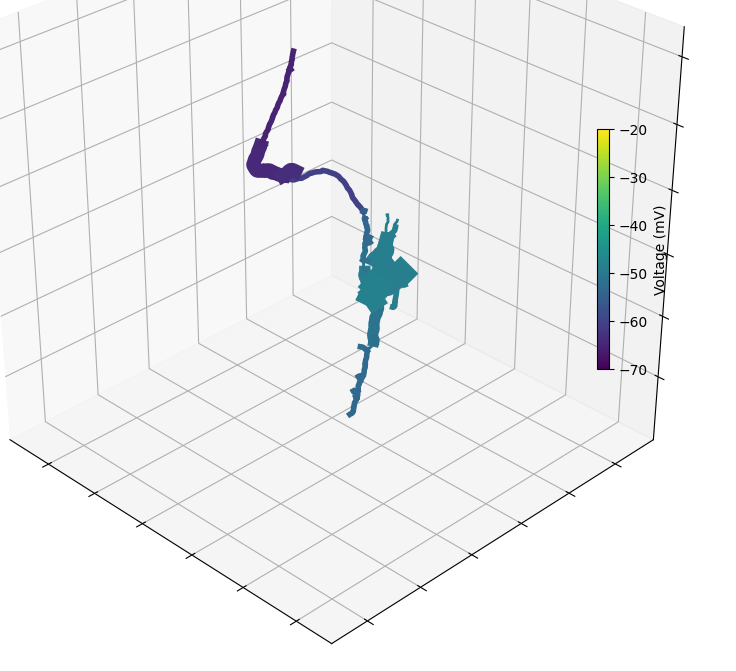

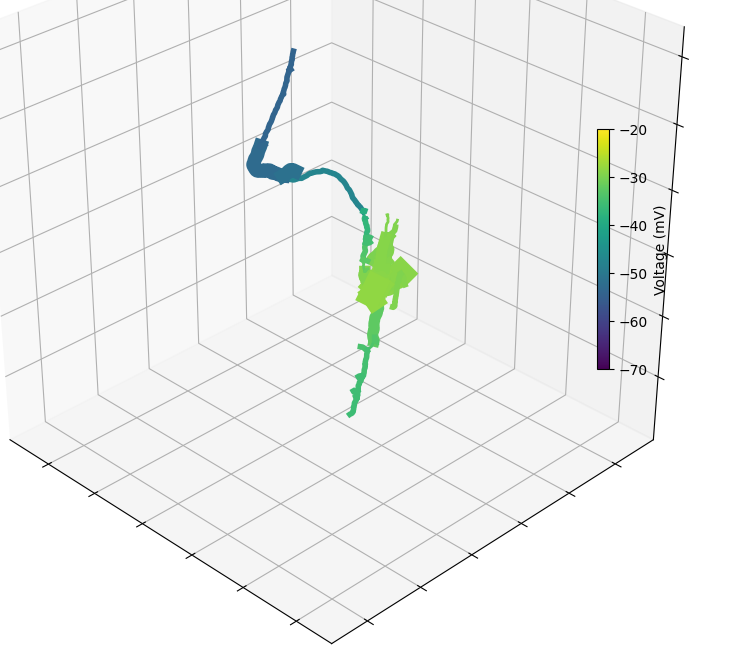

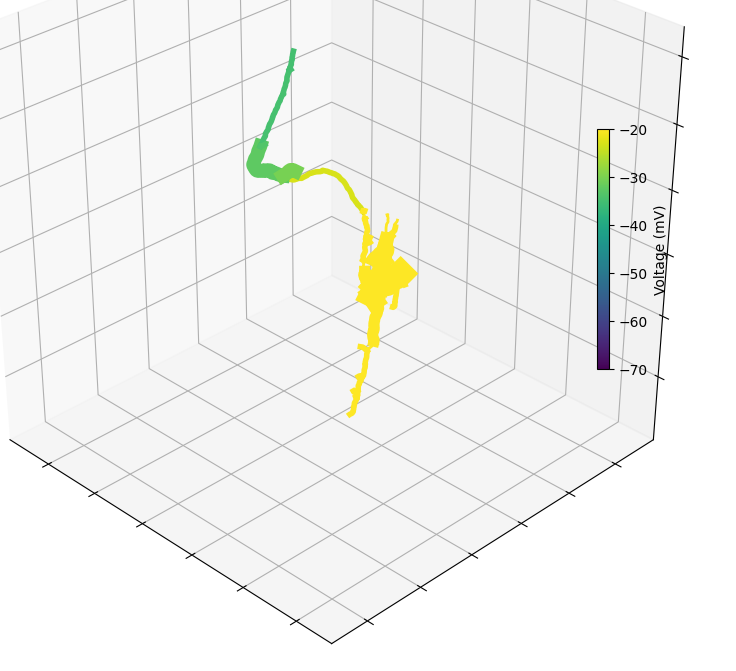

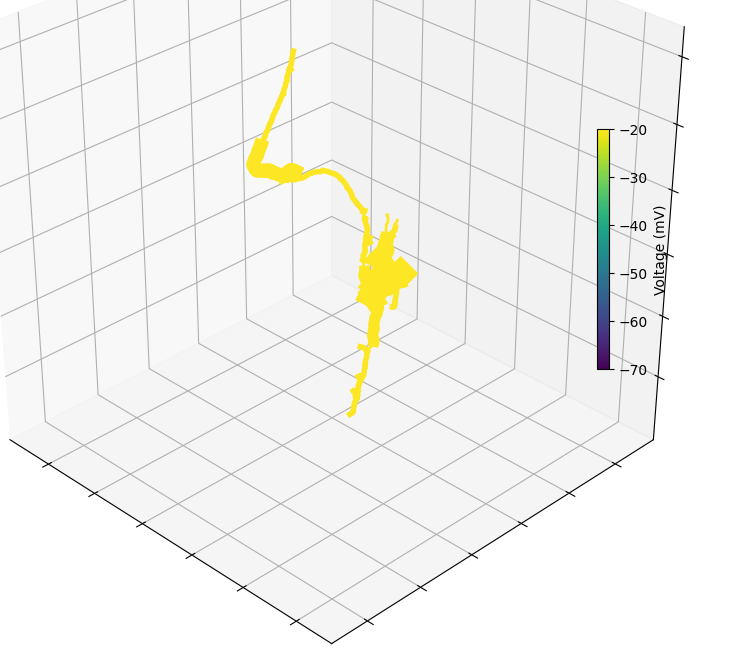

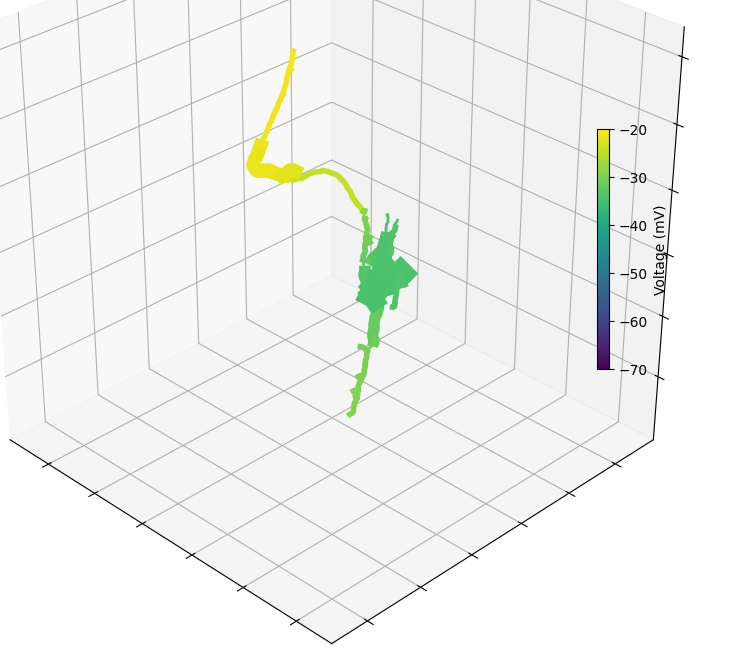

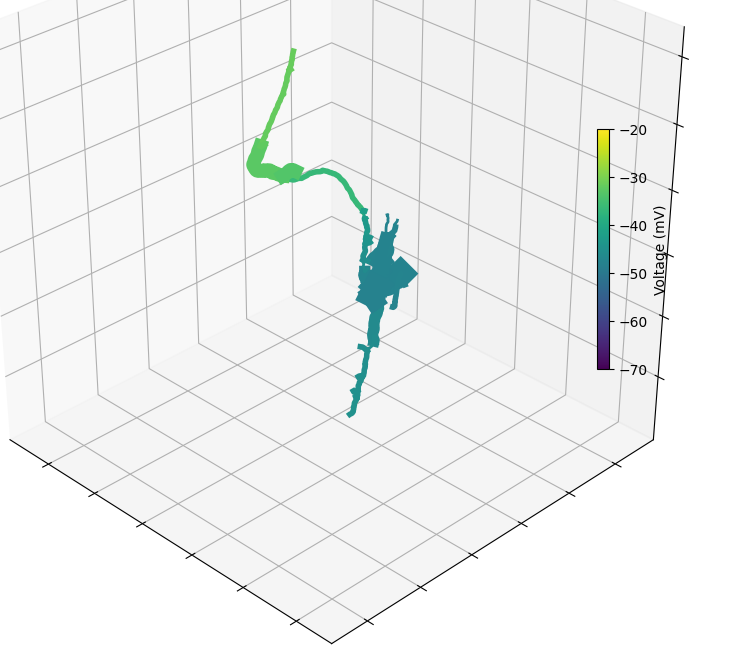

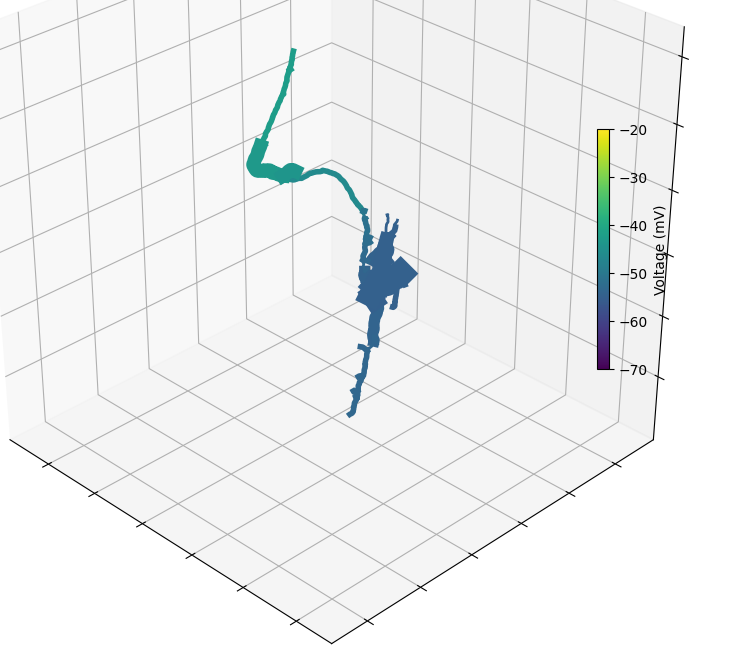

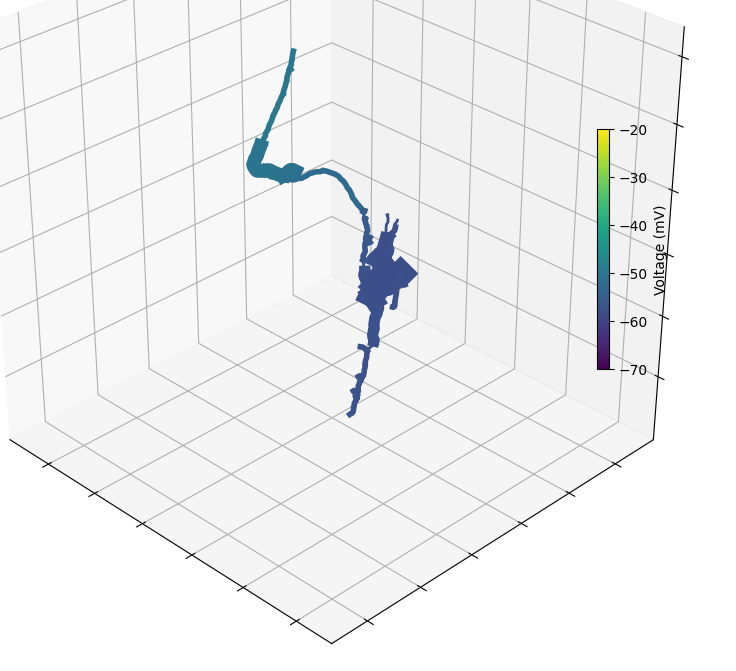

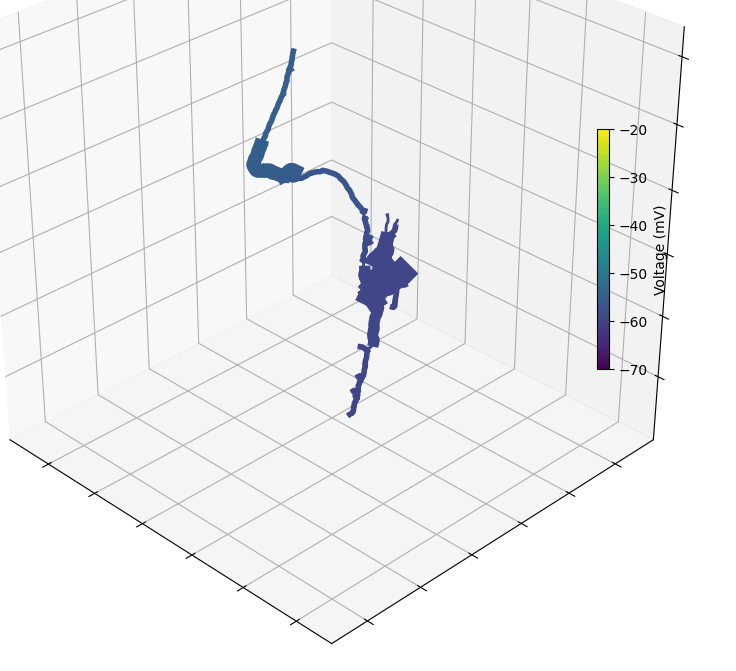

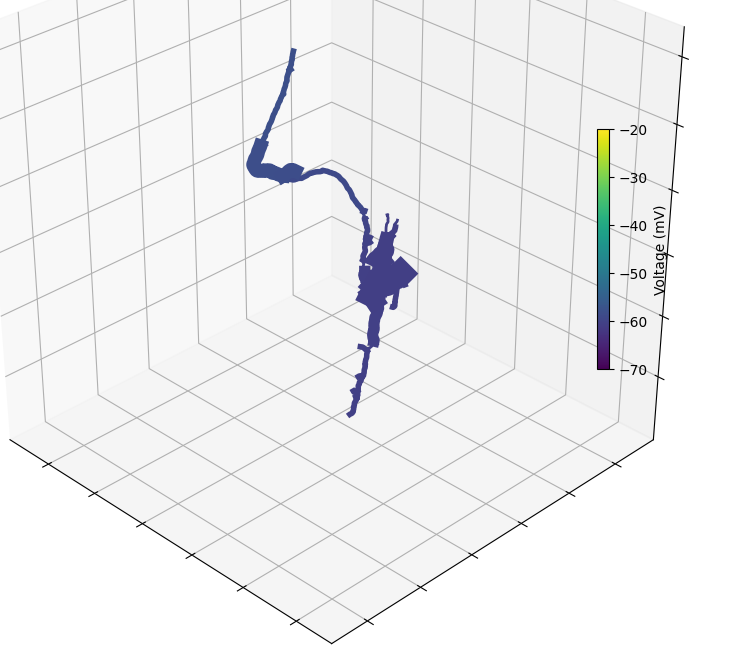

In [58]:
%matplotlib inline
sim.runSimWithIntervalFunc(1.0, my_plotShape, timeRange=[10, 20], funcArgs={'folder':folder})

This will execute `sim.analysis.plotShape` every 1.0 ms from 10 to 20 ms in the simulation and feed it the plotArgs dictionary we created above.

Once we're done simulating, we need to wrap up the final steps manually:


Gathering data...
  Done; gather time = 0.07 s.

Analyzing...
  Cells: 3
  Connections: 8 (2.67 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.0 s; 1 workers
  Run time: 2.49 s
Plotting recorded cell traces ... cell


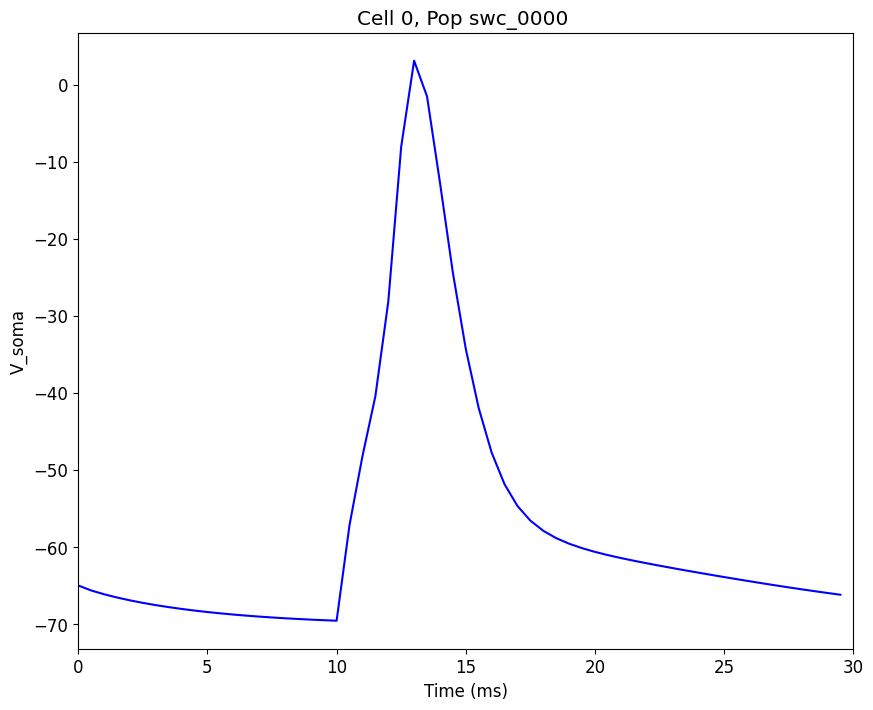

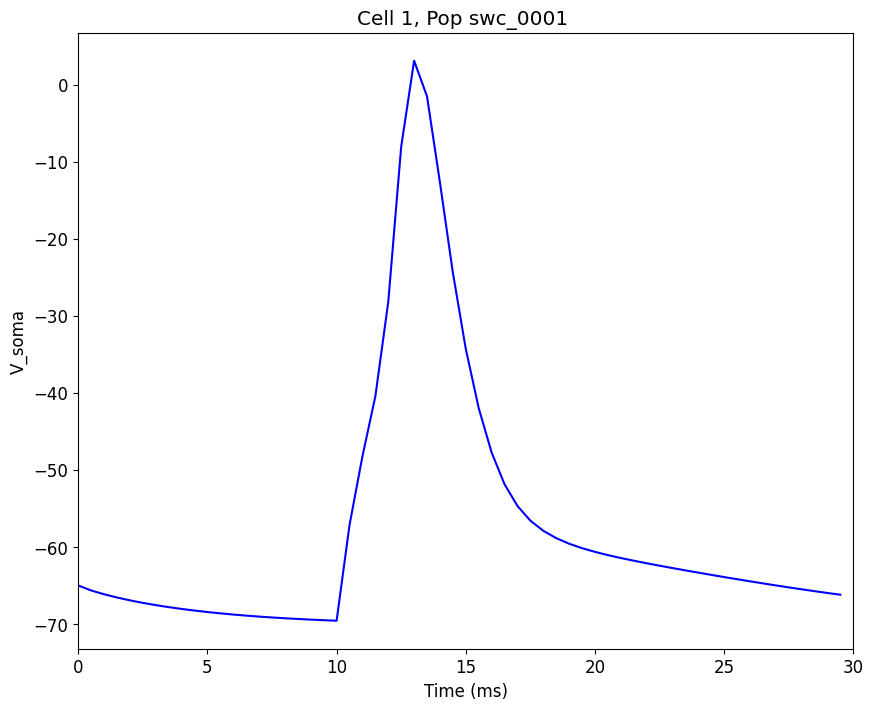

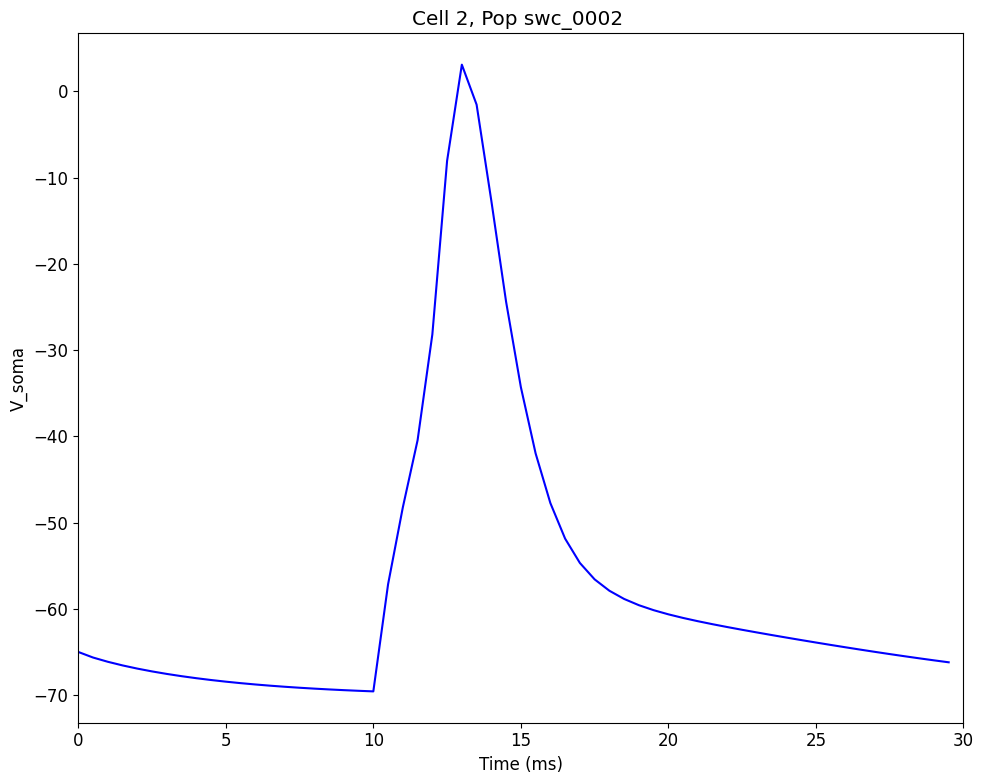

Plotting 2D representation of network cell locations and connections...


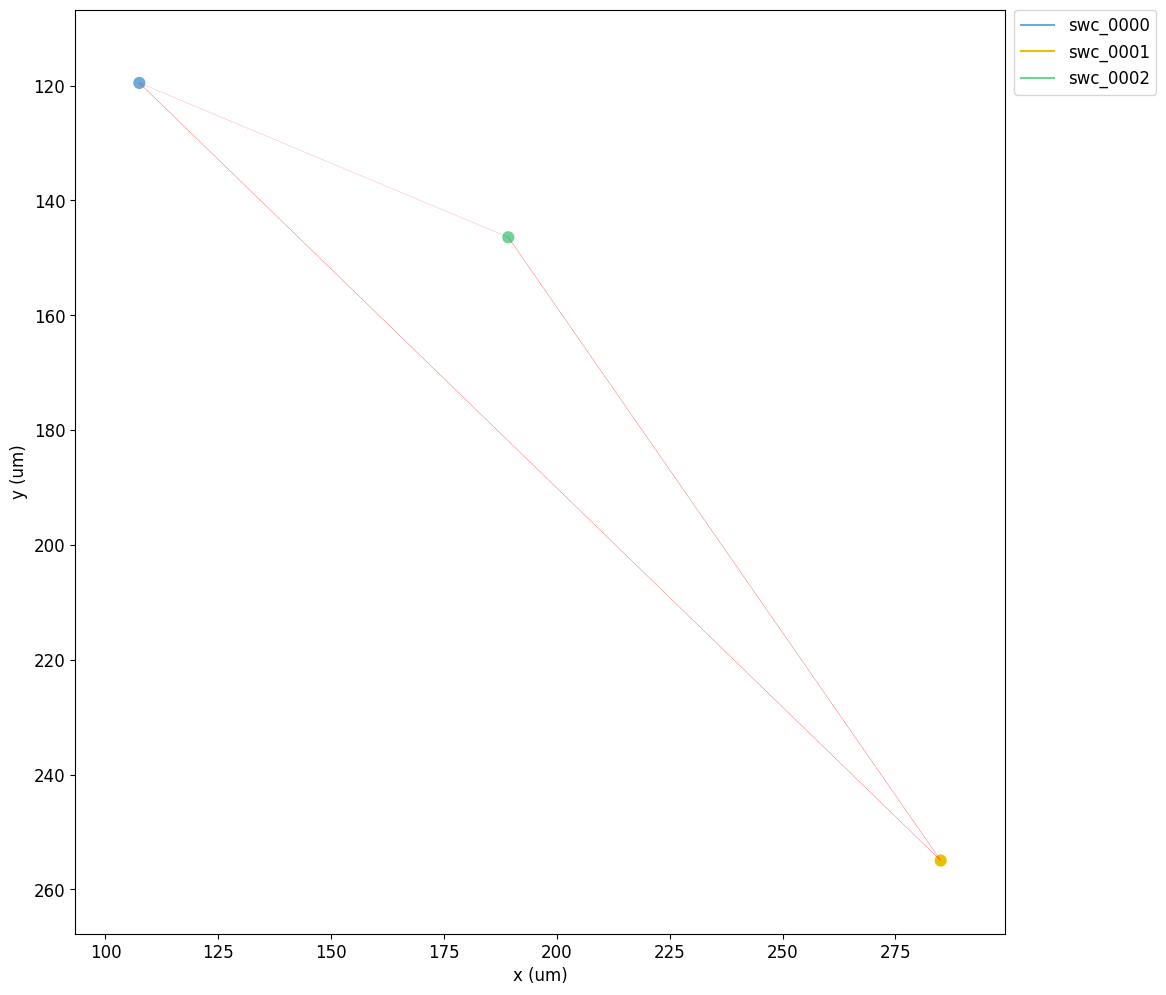

  Done; plotting time = 0.52 s


In [59]:
sim.gatherData()
sim.saveData()
sim.analysis.plotData()

Once everything is complete, we'll need to install a couple Python packages to make a movie from our frames.

```python
!python3 -m pip install natsort imageio
```

Then the following will create an animated gif from the individual figures.

In [73]:
import os
import natsort
import imageio

images = []
frame_fnames = natsort.natsorted([os.path.join(frame_dir, file) for file in os.listdir(frame_dir) if 'frame' in file and file.endswith('.png')])
for frame_fname in frame_fnames:
    print('.',end='')
    images.append(imageio.imread(frame_fname))
    
gif_fname = os.path.splitext(filename)[0]+'.gif'
imageio.mimsave(gif_fname, images)

print(f'Saved .gif to {gif_fname}')

..........Saved .gif to synthetic-3-cells.gif


In [69]:
import ipywidgets as widgets
display(widgets.HTML(f'<img src="{gif_fname}" width="750" align="center">'))

HTML(value='<img src="synthetic-3-cells.gif" width="750" align="center">')